<a href="https://colab.research.google.com/github/alexshamblin879/Alex-Shamblin/blob/main/sprint_challenge/DS_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [2]:
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [3]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE
df = pd.read_csv(url, index_col='game_id')
print(df.head())

          game_event_id    player_name  period  minutes_remaining  \
game_id                                                             
20900015              4  Stephen Curry       1                 11   
20900015             17  Stephen Curry       1                  9   
20900015             53  Stephen Curry       1                  6   
20900015            141  Stephen Curry       2                  9   
20900015            249  Stephen Curry       2                  2   

          seconds_remaining          action_type       shot_type  \
game_id                                                            
20900015                 25            Jump Shot  3PT Field Goal   
20900015                 31  Step Back Jump shot  2PT Field Goal   
20900015                  2            Jump Shot  2PT Field Goal   
20900015                 49            Jump Shot  2PT Field Goal   
20900015                 19            Jump Shot  2PT Field Goal   

                shot_zone_basic        

In [4]:
type(df.index)

pandas.core.indexes.base.Index

**Task 1 Testing**

In [5]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [6]:
"""T2. Create new feature"""

# YOUR CODE HERE
#Homecourt Advantage
df['homecourt_advantage'] = (df['htm'] == 'GSW').astype(int)

#Opponent
df['opponent'] = df.apply(lambda row: row['vtm'] if row['htm'] == 'GSW' else row['htm'], axis=1 )

#Seconds Remaining in Period
df['seconds_remaining_in_period'] = (df['minutes_remaining'] * 60) + df['seconds_remaining']

**Task 2 Test**

In [7]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [8]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
y = df['shot_made_flag']
X = df.drop(columns='shot_made_flag')

**Task 3 Test**

In [9]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [16]:
'''T4. Create training and val'''
# YOUR CODE HERE

# Filter data based on 'game_date' column to create training, validation, and test sets.
# Assuming 'game_date' is in the format 'YYYY-MM-DD'

# Training set: 2009-10 to 2016-17 seasons
X_train = X[(X['game_date'] >= '2009-10-01') & (X['game_date'] <= '2017-06-30')]
y_train = y[(X['game_date'] >= '2009-10-01') & (X['game_date'] <= '2017-06-30')]

# Validation set: 2017-18 season
X_val = X[(X['game_date'] >= '2017-10-01') & (X['game_date'] <= '2018-06-30')]
y_val = y[(X['game_date'] >= '2017-10-01') & (X['game_date'] <= '2018-06-30')]

# Test set: 2018-19 season
X_test = X[(X['game_date'] >= '2018-10-01') & (X['game_date'] <= '2019-06-30')]
y_test = y[(X['game_date'] >= '2018-10-01') & (X['game_date'] <= '2019-06-30')]

**Test 4**

In [17]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [18]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''
from sklearn.metrics import accuracy_score
# YOUR CODE HERE
majority_class = y_train.mode()[0]
baseline_predictions = [majority_class] * len(y_train)
baseline_acc = accuracy_score(y_train, baseline_predictions)


print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [19]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [20]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer


# YOUR CODE HERE
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create a pipeline with an OrdinalEncoder for categorical features and a DecisionTreeClassifier
model = Pipeline([
    ('encoder', OrdinalEncoder(cols=categorical_features, handle_unknown='value', handle_missing='value')),  # Encode categorical features
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Use a DecisionTreeClassifier
])

# Fit the model to the training data
model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'game_date', 'htm',
                                      'vtm', 'season_type', 'opponent'],
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
St...
Playoffs          2
NaN              -2
dtype: int64},
                                         {'col': 'opponent',
                                          'data_type': dtype('O'),
                                          'mapping': HOU     1
PHX     2
MEM     3
LAC     4
SAC     5
MIN     6
IND     7
MIL     8
CLE     9
BOS    10
POR    11
DAL    12
SAS    13
LAL    14
DEN    15
ORL    16
OKC    17
NJN    18
CHI    19
DET    20
PHI    21
WAS    22
NOH    23
MIA    24
CHA    25
UTA    26
ATL    27
TOR    28
NYK    29
BKN    30
NOP    31
NaN    -2
dtype: int64}])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('classifier', DecisionTreeClassifier(random_state=42))])

**Task 6 Testing**

In [21]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [22]:
'''T7. Calculate train and test accuracy.'''
from sklearn.metrics import accuracy_score

# YOUR CODE HERE
# Get predictions for training data
y_train_pred = model.predict(X_train)

# Get predictions for validation data
y_val_pred = model.predict(X_val)

# Calculate training accuracy
train_acc = accuracy_score(y_train, y_train_pred)

# Calculate validation accuracy
val_acc = accuracy_score(y_val, y_val_pred)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5436643835616438


**Task 7 Test**

In [23]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [24]:
'''T8. Tune model.'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# YOUR CODE HERE

# Define the hyperparameter grid
param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20],  # Explore different max_depth values
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=3,  # Limit iterations for auto-grader
    scoring='accuracy',  # Use accuracy as the scoring metric
    cv=None,  # No cross-validation since we have a validation set
    random_state=42  # Set random state for reproducibility
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best model from the search
best_model = random_search.best_estimator_

# Calculate accuracy on the test set using the best model
test_acc = accuracy_score(y_test, best_model.predict(X_test))

print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.620245757753072


**Task 8 Testing**

In [25]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

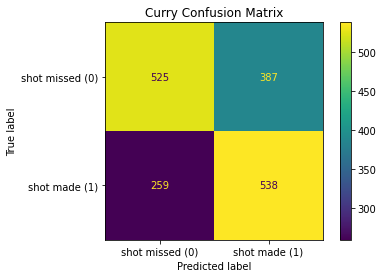

In [26]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
# Assuming the confusion matrix is given as:
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]

# Example confusion matrix values (replace with actual values from the image)
true_negatives = 840
false_positives = 225
false_negatives = 389
true_positives = 255

# Calculate precision
instructor_precision = true_positives / (true_positives + false_positives)

# Calculate recall
instructor_recall = true_positives / (true_positives + false_negatives)

print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.53125
Instuctor model recall 0.39596273291925466


**Task 9 Testing**

In [27]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

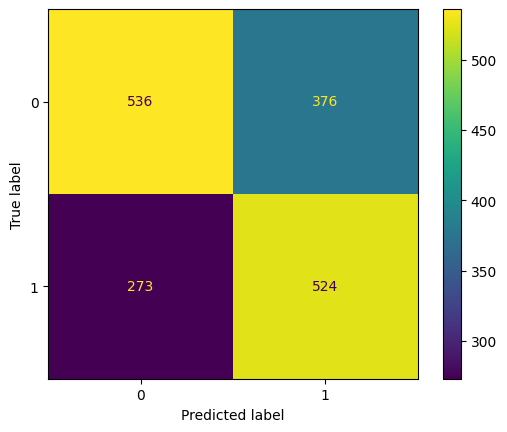

In [28]:
'''T10. Plot Confusion Matrix'''
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions for the test set
y_test_pred = best_model.predict(X_test) # Assuming best_model from Task 8

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_) # Assuming best_model from Task 8

# Plot the confusion matrix
disp.plot()
plt.show()